# Computed Tomography Analysis using DL

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import os
import pandas as pd
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, RandomBrightness, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

2024-05-13 20:01:58.868458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 20:01:58.868577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 20:01:59.053175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Mon May 13 20:02:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

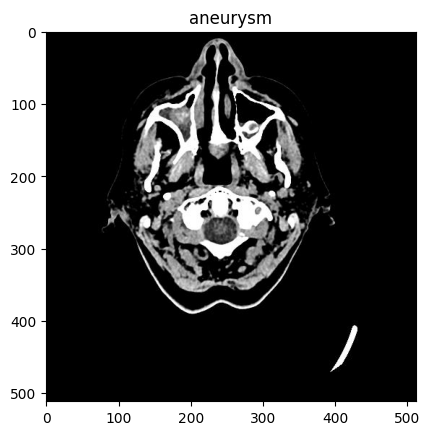

In [3]:
img = cv2.imread("/kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/10.jpg")
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')
plt.show()

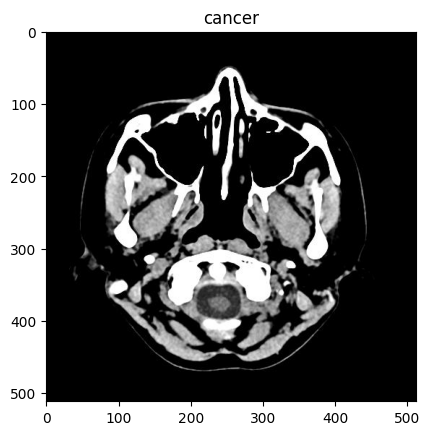

In [4]:
img = cv2.imread("/kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/20.jpg")
plt.title('cancer')
plt.imshow(img, label = 'cancer')
plt.show()

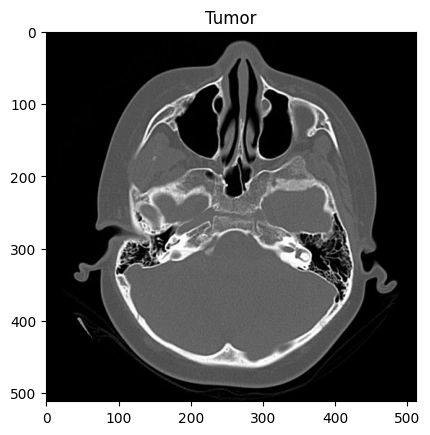

In [5]:
img = cv2.imread("/kaggle/input/computed-tomography-ct-of-the-brain/files/tumor/15.jpg")
plt.title('Tumor')
plt.imshow(img, label = 'Tumor Case')
plt.show()

## EDA

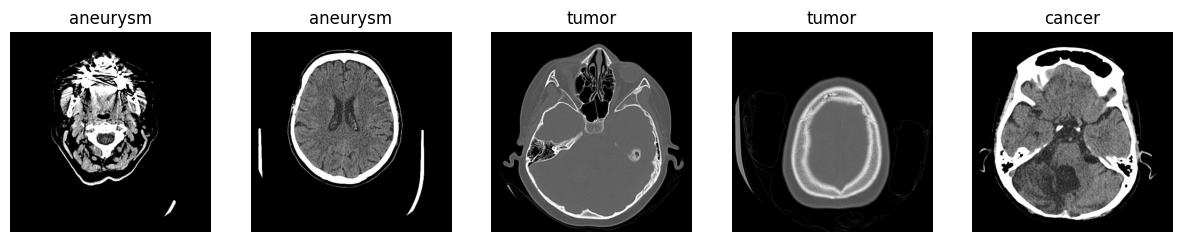

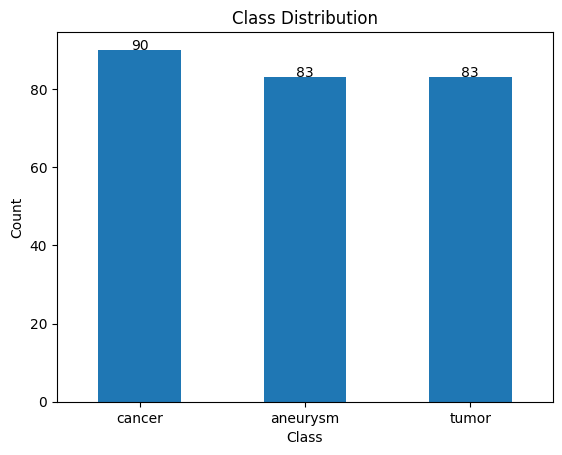

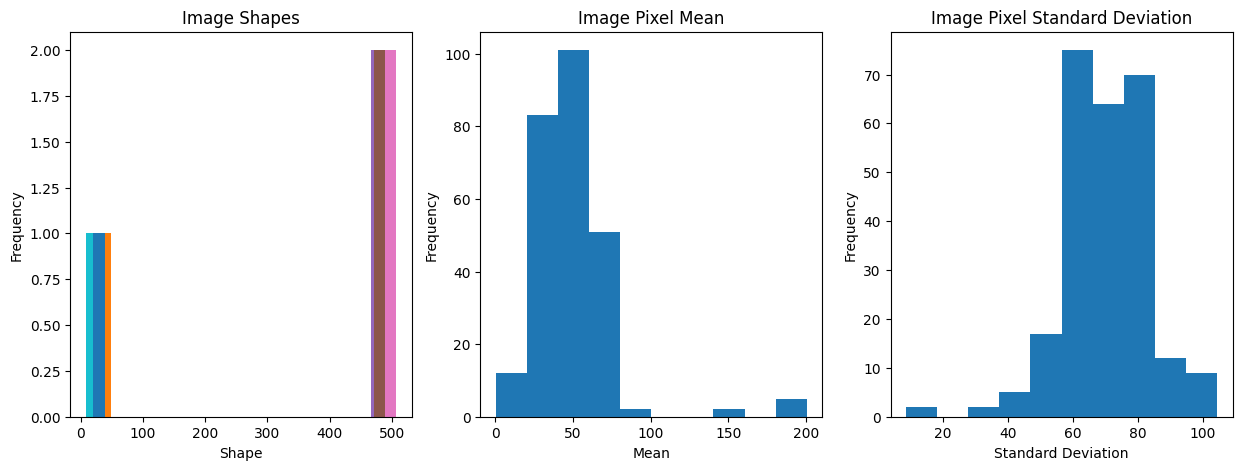

In [6]:

def load_image(file_path):
    """
    Load an image from file.

    Args:
    - file_path: Path to the image file.

    Returns:
    - img: Loaded image as a numpy array.
    """
    img = cv2.imread(file_path)
    return img

def display_sample_images(image_paths, labels, num_samples=5):
    """
    Display sample images from the dataset.

    Args:
    - image_paths: List of paths to image files.
    - labels: List of corresponding labels for the images.
    - num_samples: Number of sample images to display (default: 5).
    """
    buff = 0
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(5):
        img_path = os.path.join('/kaggle/input/computed-tomography-ct-of-the-brain/files', image_paths[i+buff][1:])
        # print("Image Path:", img_path)
        img = cv2.imread(img_path)
        if img is not None:
            # print("Image Loaded Successfully.")
            # print("Image dtype:", img.dtype)
            axes[i].imshow(img)
            axes[i].set_title(labels[i+buff])
            axes[i].axis('off')
        else:
            print("Error: Unable to load image.")
        buff += 50
    plt.show()


def plot_class_distribution(labels):
    """
    Plot the distribution of classes in the dataset.

    Args:
    - labels: List of class labels.
    """
    class_counts = pd.Series(labels).value_counts()
    class_counts.plot(kind='bar', rot=0)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')

    # Add counts over bars
    for i, count in enumerate(class_counts):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.show()

def visualize_image_statistics(images):
    """
    Visualize statistics of image data.

    Args:
    - images: List of image arrays.
    """
    image_shapes = [img.shape for img in images]
    image_means = [np.mean(img) for img in images]
    image_stds = [np.std(img) for img in images]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].hist(image_shapes)
    axes[0].set_title('Image Shapes')
    axes[0].set_xlabel('Shape')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(image_means)
    axes[1].set_title('Image Pixel Mean')
    axes[1].set_xlabel('Mean')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(image_stds)
    axes[2].set_title('Image Pixel Standard Deviation')
    axes[2].set_xlabel('Standard Deviation')
    axes[2].set_ylabel('Frequency')

    plt.show()

def perform_eda(dataset_folder):
    """
    Perform exploratory data analysis (EDA) on the image dataset.

    Args:
    - dataset_folder: Path to the dataset folder containing image files.
    """
    # Load dataset information from .csv file
    dataset_info = pd.read_csv(os.path.join(dataset_folder, 'ct_brain.csv'))

    # Display sample images
    display_sample_images(dataset_info['jpg'], dataset_info['type'])

    # Plot class distribution
    plot_class_distribution(dataset_info['type'])

    # Load images and visualize image statistics
    images = []
    # print(dataset_info['jpg'])
    for file_path in dataset_info['jpg']:
        img = load_image(os.path.join('/kaggle/input/computed-tomography-ct-of-the-brain/files', file_path[1:]))
        images.append(img)
    visualize_image_statistics(images)

# Example usage:
dataset_folder = r"/kaggle/input/computed-tomography-ct-of-the-brain/"
perform_eda(dataset_folder)



## EDA-for ".dcm" files

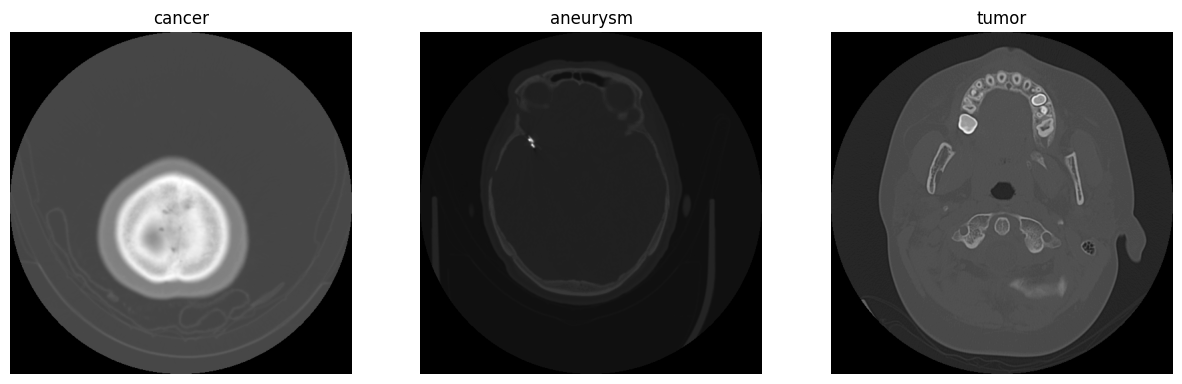

Number of classes: 3
Classes: cancer, aneurysm, tumor
Number of samples: 256

Class: cancer
                   dcm             jpg    type
count               90              90      90
unique              90              90       1
top     /cancer/90.dcm  /cancer/90.jpg  cancer
freq                 1               1      90

Class: aneurysm
                     dcm               jpg      type
count                 83                83        83
unique                83                83         1
top     /aneurysm/83.dcm  /aneurysm/83.jpg  aneurysm
freq                   1                 1        83

Class: tumor
                  dcm            jpg   type
count              83             83     83
unique             83             83      1
top     /tumor/83.dcm  /tumor/83.jpg  tumor
freq                1              1     83


In [7]:
import pydicom
# Set the path to your dataset directory
data_dir = "/kaggle/input/computed-tomography-ct-of-the-brain"

# Read the CSV file
df = pd.read_csv(os.path.join(data_dir, 'ct_brain.csv'))

# Define the classes
classes = ['cancer', 'aneurysm', 'tumor']

# Create a dictionary to store sample images for each class
sample_images = {c: [] for c in classes}

# Loop through each class and load a sample of .dcm files
for cls in classes:
    cls_dir = os.path.join(data_dir, 'files', cls)
    dcm_files = [f for f in os.listdir(cls_dir) if f.endswith('.dcm')]
    
    # Load a sample of 3 .dcm files
    for dcm_file in np.random.choice(dcm_files, size=3, replace=False):
        dcm_path = os.path.join(cls_dir, dcm_file)
        ds = pydicom.dcmread(dcm_path)
        sample_images[cls].append(ds.pixel_array)

# Visualize a sample image from each class
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    axs[i].imshow(sample_images[cls][0], cmap='gray')
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.show()

# Print basic information about the dataset
print(f'Number of classes: {len(classes)}')
print(f'Classes: {", ".join(classes)}')
print(f'Number of samples: {len(df)}')

# Print summary statistics for each class
for cls in classes:
    cls_data = df[df['type'] == cls]
    print(f'\nClass: {cls}')
    print(cls_data.describe())

## Train-Test split

In [8]:

# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    classes = os.listdir(dir)
    for class_name in classes:
        if os.path.isdir(os.path.join(dir, class_name)):
            class_path = os.path.join(dir, class_name)
            filelist = os.listdir(class_path)
            for file in filelist:
                fpath = os.path.join(class_path, file[1:])
                if fpath.endswith('.jpg'):
                    filepaths.append(fpath)
                    labels.append(class_name)
    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Split data into train, validation, and test
def split_data(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df, test_df = train_valid_test_split(df, train_size=0.7, valid_size=0.10, test_size=0.2, shuffle=True, random_state=123, stratify=strat)
    return train_df, valid_df, test_df

# Custom train, validation, test split function
def train_valid_test_split(df, train_size, valid_size, test_size, shuffle=True, random_state=None, stratify=None):
    assert train_size + valid_size + test_size == 1.0, "The sum of train_size, valid_size, and test_size should be 1.0"

    if shuffle:
        df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    num_samples = len(df)
    train_end = int(train_size * num_samples)
    valid_end = int((train_size + valid_size) * num_samples)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df


# Get Dataframes
data_dir = "/kaggle/input/computed-tomography-ct-of-the-brain/files"
train_df, valid_df, test_df = split_data(data_dir)

# Display the head of each dataframe
print("Train Data:")
print(train_df.head())
print("")
print(train_df.tail())
print("")

print("Validation Data:")
print(valid_df.head())
print("")
print(valid_df.tail())
print("")

print("Test Data:")
print(test_df.head())
print("")
print(test_df.tail())

Train Data:
                                           filepaths    labels
0  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
1  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
2  /kaggle/input/computed-tomography-ct-of-the-br...     tumor
3  /kaggle/input/computed-tomography-ct-of-the-br...     tumor
4  /kaggle/input/computed-tomography-ct-of-the-br...     tumor

                                             filepaths    labels
176  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
177  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
178  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
179  /kaggle/input/computed-tomography-ct-of-the-br...     tumor
180  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm

Validation Data:
                                             filepaths    labels
181  /kaggle/input/computed-tomography-ct-of-the-br...     tumor
182  /kaggle/input/computed-tomography-ct-of-the-br...  aneurysm
183  /

In [9]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes
         data from image data generator.
         Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                            color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                           color_mode= color, shuffle= False, batch_size= test_batch_size)


    return train_gen, valid_gen, test_gen
Batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, Batch_size)


Found 157 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Found 48 validated image filenames belonging to 3 classes.


In [10]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator


    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)

        # note
        index = np.argmax(labels[i])  # get image index

        class_name = classes[index]   # get class of image

        plt.title(class_name, color= 'blue', fontsize= 8)
        plt.axis('off')
    plt.show()

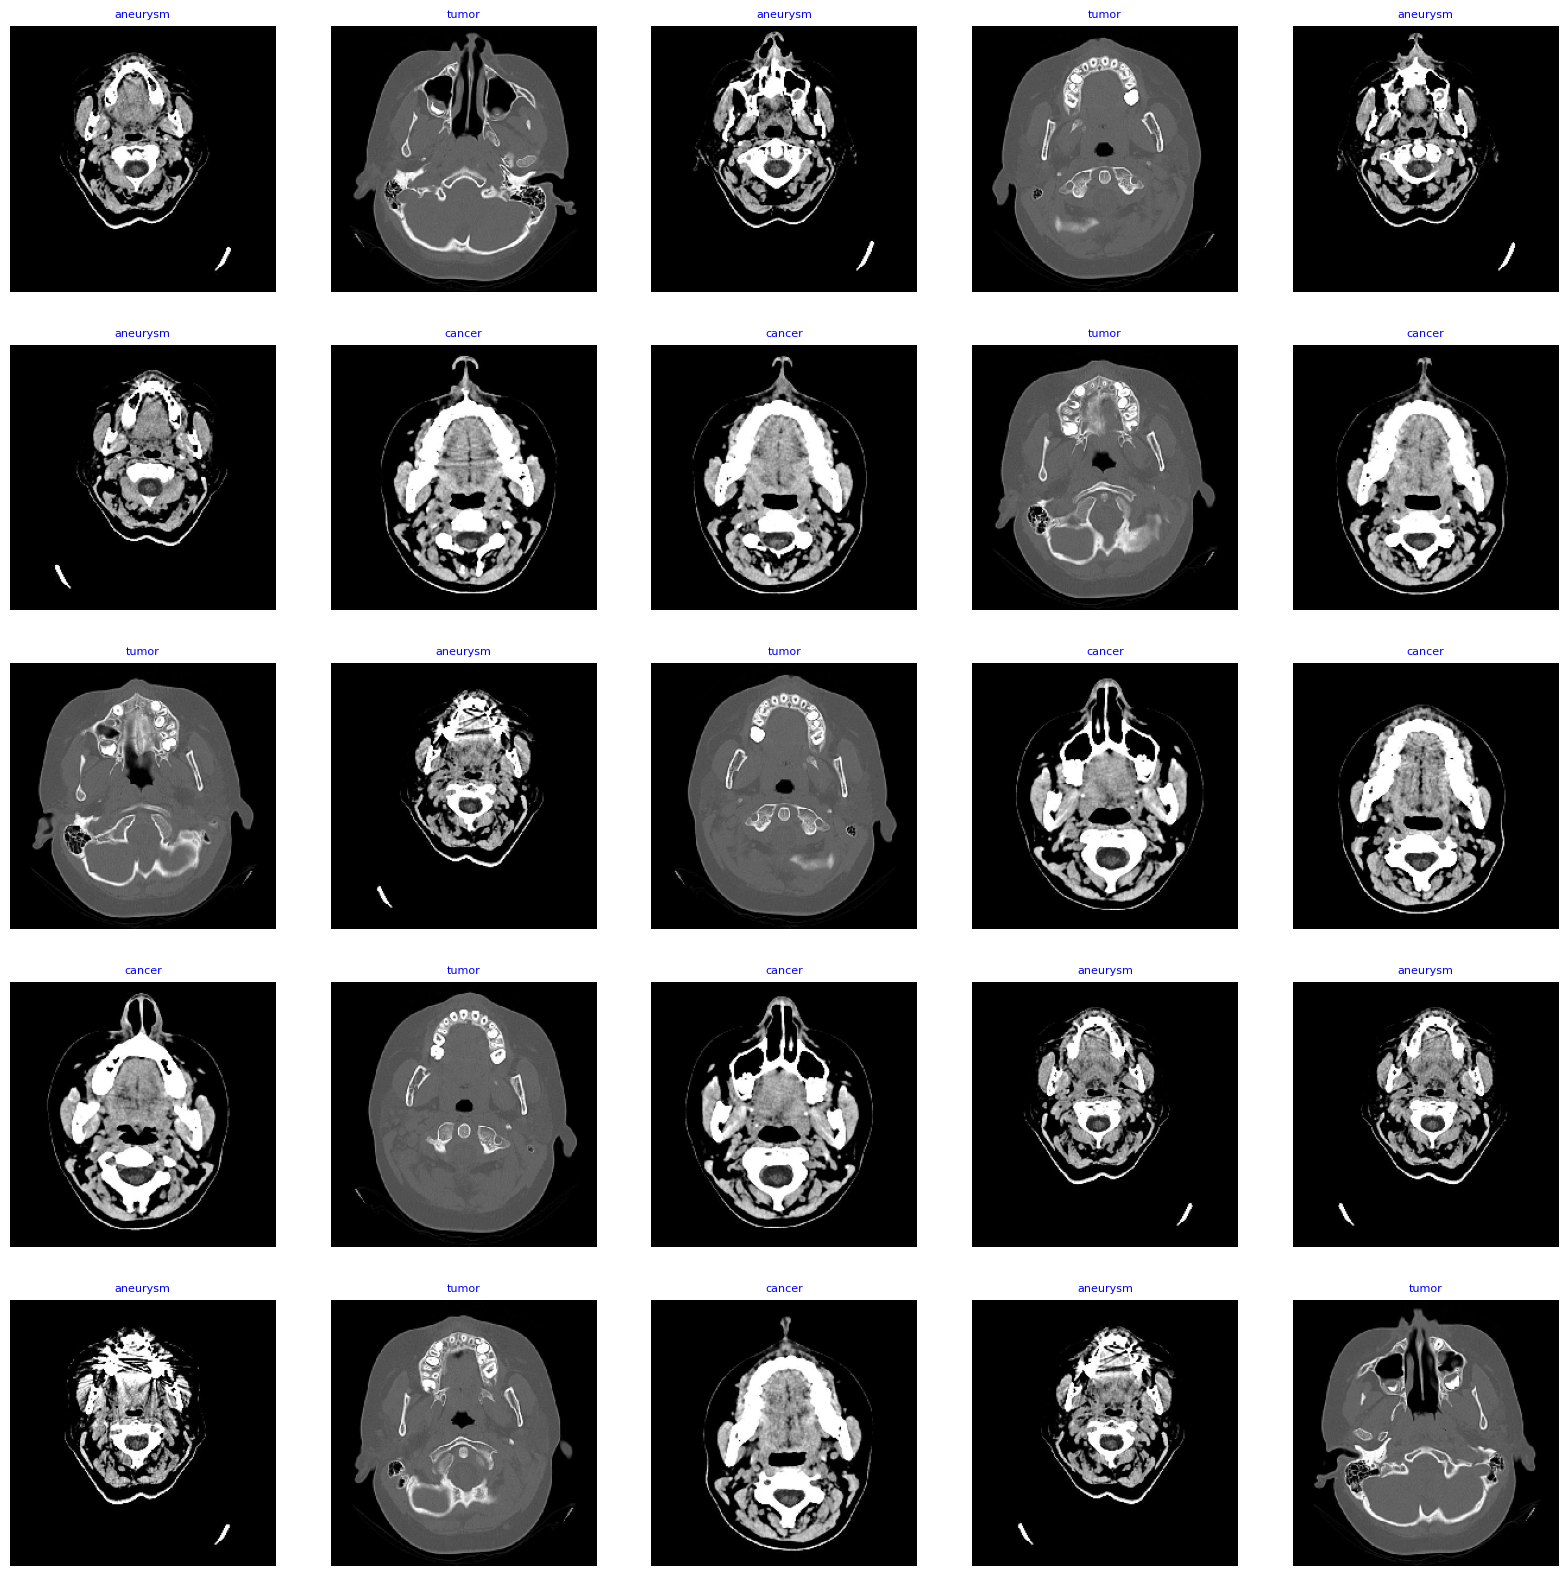

In [11]:
# Display Image Samples
show_images(train_gen)

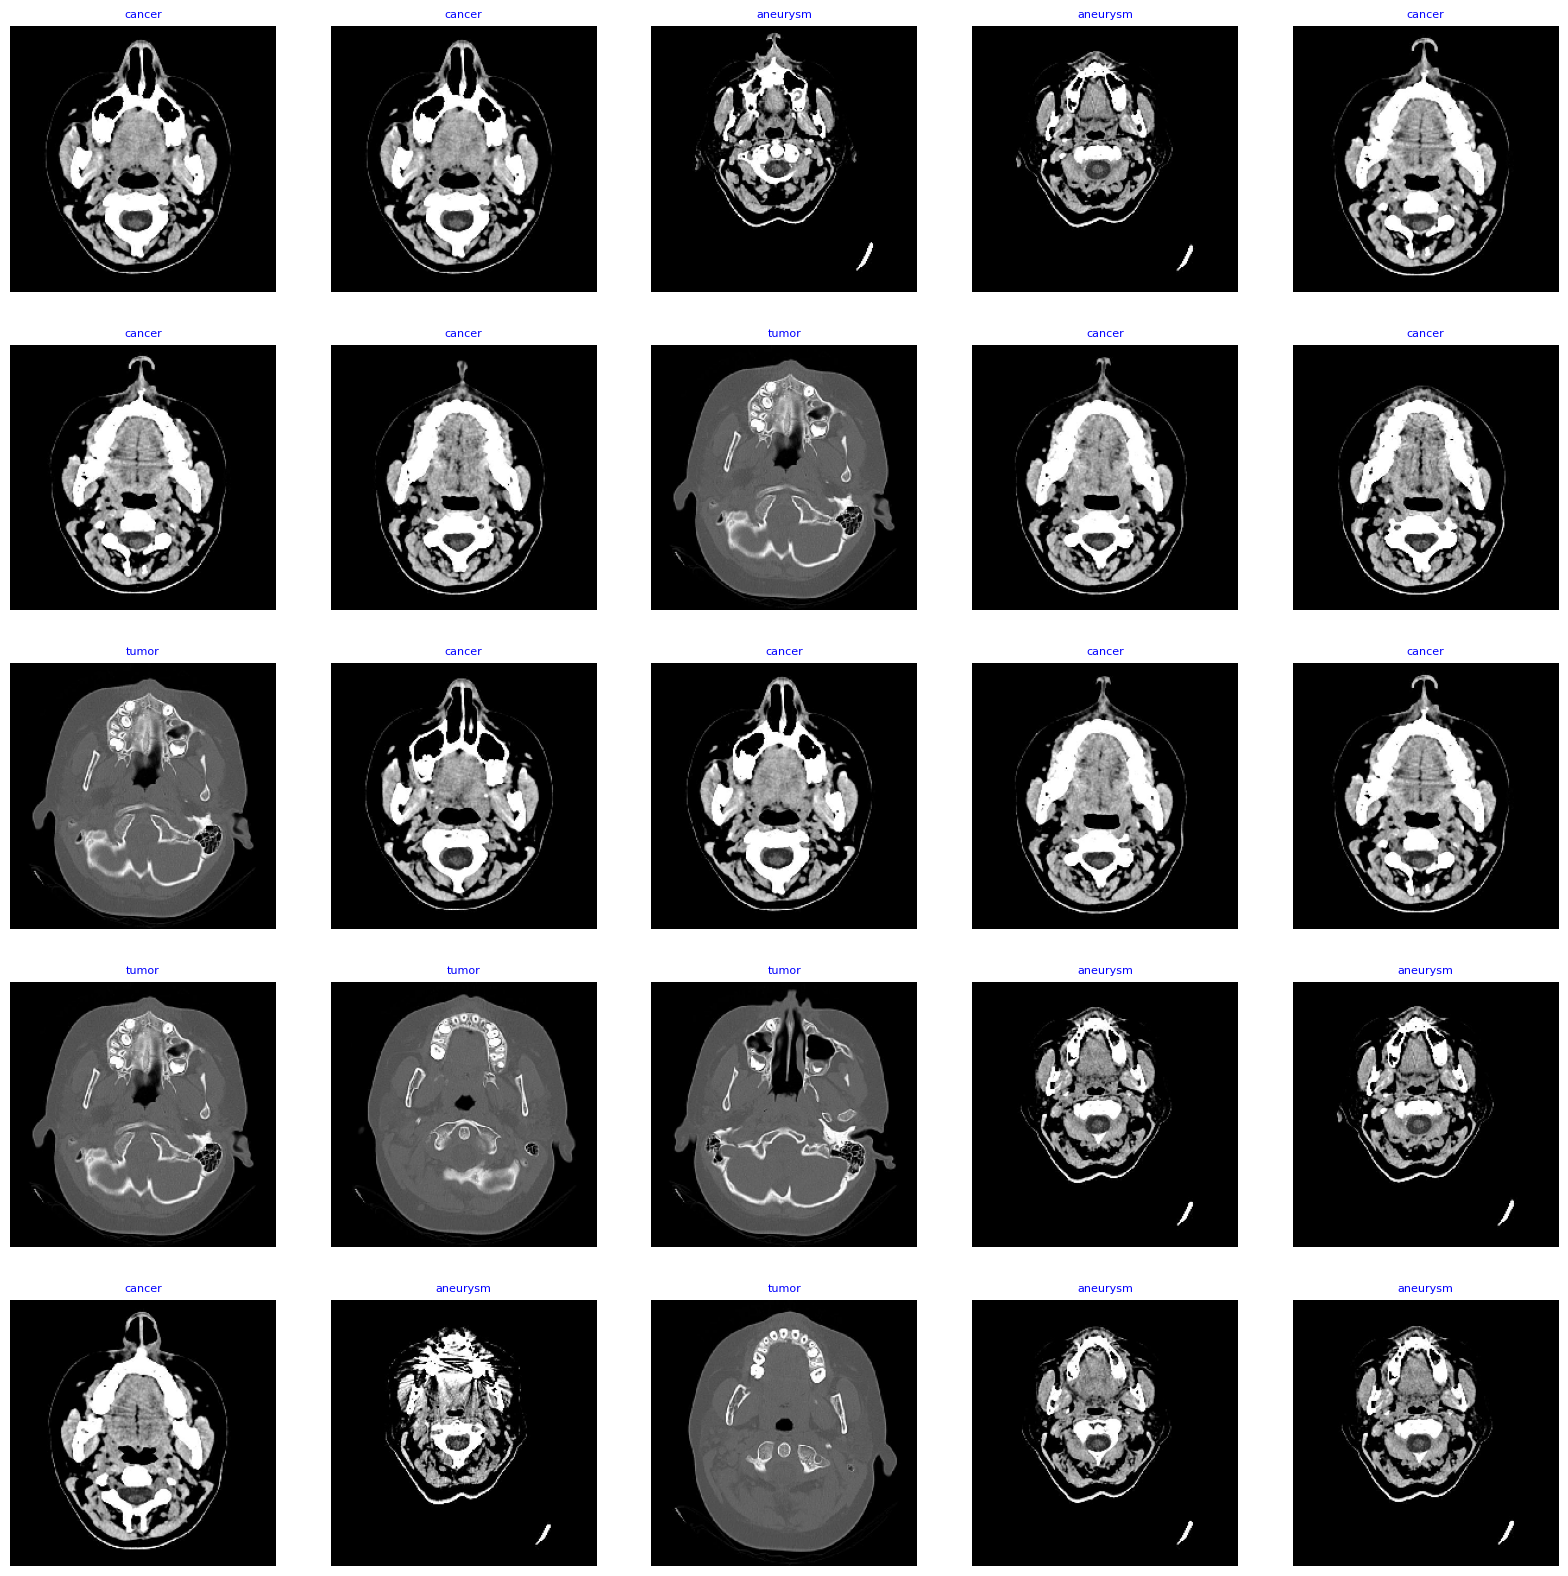

In [12]:
show_images(test_gen)

# Model Selection

## 1.VGG-16

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
# base_model.trainable = False

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
vgg_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(124, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
vgg_model.summary()




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### Defining callbacks

In [14]:
# import tensorflow as tf
# import time
# import numpy as np
# import keras

# class MyCallback(keras.callbacks.Callback):
#     def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
#         super(MyCallback, self).__init__()
#         self.model = model
#         self.patience = patience  # Specifies how many epochs without improvement before adjusting learning rate
#         self.stop_patience = stop_patience  # Specifies how many times to adjust LR without improvement to stop training
#         self.threshold = threshold  # Specifies training accuracy threshold when LR will be adjusted based on validation loss
#         self.factor = factor  # Factor by which to reduce the learning rate
#         self.batches = batches  # Number of training batches to run per epoch
#         self.epochs = epochs
#         self.ask_epoch = ask_epoch
#         self.ask_epoch_initial = ask_epoch  # Save this value to restore if restarting training
#         self.ask_permission = None

#         # Callback variables
#         self.count = 0  # How many times LR has been reduced without improvement
#         self.stop_count = 0
#         self.best_epoch = 1   # Epoch with the lowest loss
#         self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Get initial LR and save it
#         self.highest_tracc = 0.0  # Highest training accuracy
#         self.lowest_vloss = np.inf  # Lowest validation loss
#         self.best_weights = self.model.get_weights()  # Set best weights to model's initial weights
#         self.initial_weights = self.model.get_weights()  # Save initial weights if they have to get restored

#     # Function that runs when training begins
#     def on_train_begin(self, logs=None):
#         print("Do you want the model to ask you to halt the training? [y/n]")
#         ans = input('')
#         if ans.lower() == 'y':
#             self.ask_permission = True
#         elif ans.lower() == 'n':
#             self.ask_permission = False

#         header_msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
#             'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
#         )
#         print(header_msg)
#         self.start_time = time.time()

#     # Function that runs when training ends
#     def on_train_end(self, logs=None):
#         stop_time = time.time()
#         tr_duration = stop_time - self.start_time
#         hours = tr_duration // 3600
#         minutes = (tr_duration - (hours * 3600)) // 60
#         seconds = tr_duration - ((hours * 3600) + (minutes * 60))

#         print(f'Training elapsed time was {hours} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)')

#         # Set the weights of the model to the best weights
#         self.model.set_weights(self.best_weights)

#     # Function that runs at the end of each training batch
#     def on_train_batch_end(self, batch, logs=None):
#         acc = logs.get('accuracy') * 100
#         loss = logs.get('loss')

#         msg = '{0:20s}Processing batch {1:} of {2:5s} - Accuracy: {3:5.3f} - Loss: {4:8.5f}'.format(
#             ' ', str(batch), str(self.batches), acc, loss)
#         print(msg, '\r', end='')

#     # Function that runs at the beginning of each epoch
#     def on_epoch_begin(self, epoch, logs=None):
#         self.ep_start = time.time()

#     # Function that runs at the end of each epoch
#     def on_epoch_end(self, epoch, logs=None):
#         ep_end = time.time()
#         duration = ep_end - self.ep_start

#         lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # Get current learning rate
#         current_lr = lr
#         acc = logs.get('accuracy')  # Get training accuracy
#         v_acc = logs.get('val_accuracy')  # Get validation accuracy
#         loss = logs.get('loss')  # Get training loss for this epoch
#         v_loss = logs.get('val_loss')  # Get the validation loss for this epoch

#         if acc < self.threshold:  # If training accuracy is below threshold, adjust LR based on training accuracy
#             monitor = 'accuracy'
#             if epoch == 0:
#                 pimprov = 0.0
#             else:
#                 pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc  # Define improvement of model progress

#             if acc > self.highest_tracc:  # Training accuracy improved in the epoch
#                 self.highest_tracc = acc  # Set new highest training accuracy
#                 self.best_weights = self.model.get_weights()  # Save the weights
#                 self.count = 0  # Reset count since training accuracy improved
#                 self.stop_count = 0
#                 if v_loss < self.lowest_vloss:
#                     self.lowest_vloss = v_loss
#                 self.best_epoch = epoch + 1  # Set the value of best epoch for this epoch

#             else:
#                 # Training accuracy did not improve, check if this has happened for patience number of epochs
#                 # If so, adjust learning rate
#                 if self.count >= self.patience - 1:  # LR should be adjusted
#                     lr = lr * self.factor  # Adjust the learning rate
#                     tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Set the learning rate in the optimizer
#                     self.count = 0  # Reset the count to 0
#                     self.stop_count += 1  # Count the number of consecutive LR adjustments
#                     self.count = 0  # Reset counter
#                     if v_loss < self.lowest_vloss:
#                         self.lowest_vloss = v_loss
#                 else:
#                     self.count += 1  # Increment patience counter

#         else:  # Training accuracy is above threshold so adjust LR based on validation loss
#             monitor = 'val_loss'
#             if epoch == 0:
#                 pimprov = 0.0
#             else:
#                 pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss
#             if v_loss < self.lowest_vloss:  # Check if the validation loss improved
#                 self.lowest_vloss = v_loss  # Replace lowest validation loss with new validation loss
#                 self.best_weights = self.model.get_weights()  # Save the weights
#                 self.count = 0  # Reset count since validation loss improved
#                 self.stop_count = 0
#                 self.best_epoch = epoch + 1  # Set the value of the best epoch to this epoch
#             else:  # Validation loss did not improve
#                 if self.count >= self.patience - 1:  # Need to adjust LR
#                     lr = lr * self.factor  # Adjust the learning rate
#                     self.stop_count += 1  # Increment stop counter because LR was adjusted
#                     self.count = 0  # Reset counter
#                     tf.keras.backend.set_value(self.model.optimizer.lr, lr)  # Set the learning rate in the optimizer
#                 else:
#                     self.count += 1  # Increment the patience counter
#                 if acc > self.highest_tracc:
#                     self.highest_tracc = acc

#         msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
#         print(msg)

#         if self.stop_count > self.stop_patience - 1:  # Check if LR has been adjusted stop_count times with no improvement
#             msg = f' Training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
#             print(msg)
#             self.model.stop_training = True  # Stop training

#         else:
#             if self.ask_epoch is not None and self.ask_permission is not False:
#                 if epoch + 1 >= self.ask_epoch:
#                     print('Enter H to halt training or an integer for number of epochs to run then ask again')
#                     ans = input('')
#                     if ans.lower() == 'h':
#                         msg = f'Training has been halted at epoch {epoch + 1} due to user input'
#                         print(msg)
#                         self.model.stop_training = True  # Stop training
#                     else:
#                         try:
#                             ans = int(ans)
#                             self.ask_epoch += ans
#                             print(f'Training will continue until epoch {self.ask_epoch}')
#                             header_msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
#                                 'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
#                             )
#                             print(header_msg)
#                         except ValueError:
#                             print('Invalid input')

# # Example usage:
# # my_callback = MyCallback(model, patience=5, stop_patience=3, threshold=0.95, factor=0.1, batches=100, epochs=20, ask_epoch=5)
# # callbacks = [my_callback]


In [18]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(vgg_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
history = vgg_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
#     callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


I0000 00:00:1715630673.867153     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715630673.892389     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 182s 25s/step - accuracy: 0.3219 - auc: 0.4738 - loss: 6.1886 - precision: 0.3047 - recall: 0.2839 - val_accuracy: 0.5417 - val_auc: 0.7062 - val_loss: 6.0370 - val_precision: 0.5652 - val_recall: 0.5417
Epoch 2/90


W0000 00:00:1715630774.952957     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.5434 - auc: 0.7521 - loss: 5.2688 - precision: 0.5695 - recall: 0.5101 - val_accuracy: 0.6250 - val_auc: 0.8025 - val_loss: 5.2097 - val_precision: 0.7222 - val_recall: 0.5417
Epoch 3/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.5730 - auc: 0.7719 - loss: 5.2154 - precision: 0.5921 - recall: 0.5436 - val_accuracy: 0.5833 - val_auc: 0.6597 - val_loss: 6.2485 - val_precision: 0.5833 - val_recall: 0.5833
Epoch 4/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.6416 - auc: 0.8484 - loss: 4.9910 - precision: 0.6824 - recall: 0.5929 - val_accuracy: 0.7500 - val_auc: 0.9514 - val_loss: 4.6992 - val_precision: 0.8182 - val_recall: 0.7500
Epoch 5/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.7110 - auc: 0.8608 - loss: 4.9624 - precision: 0.7177 - recall: 0.6496 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.3535 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step -

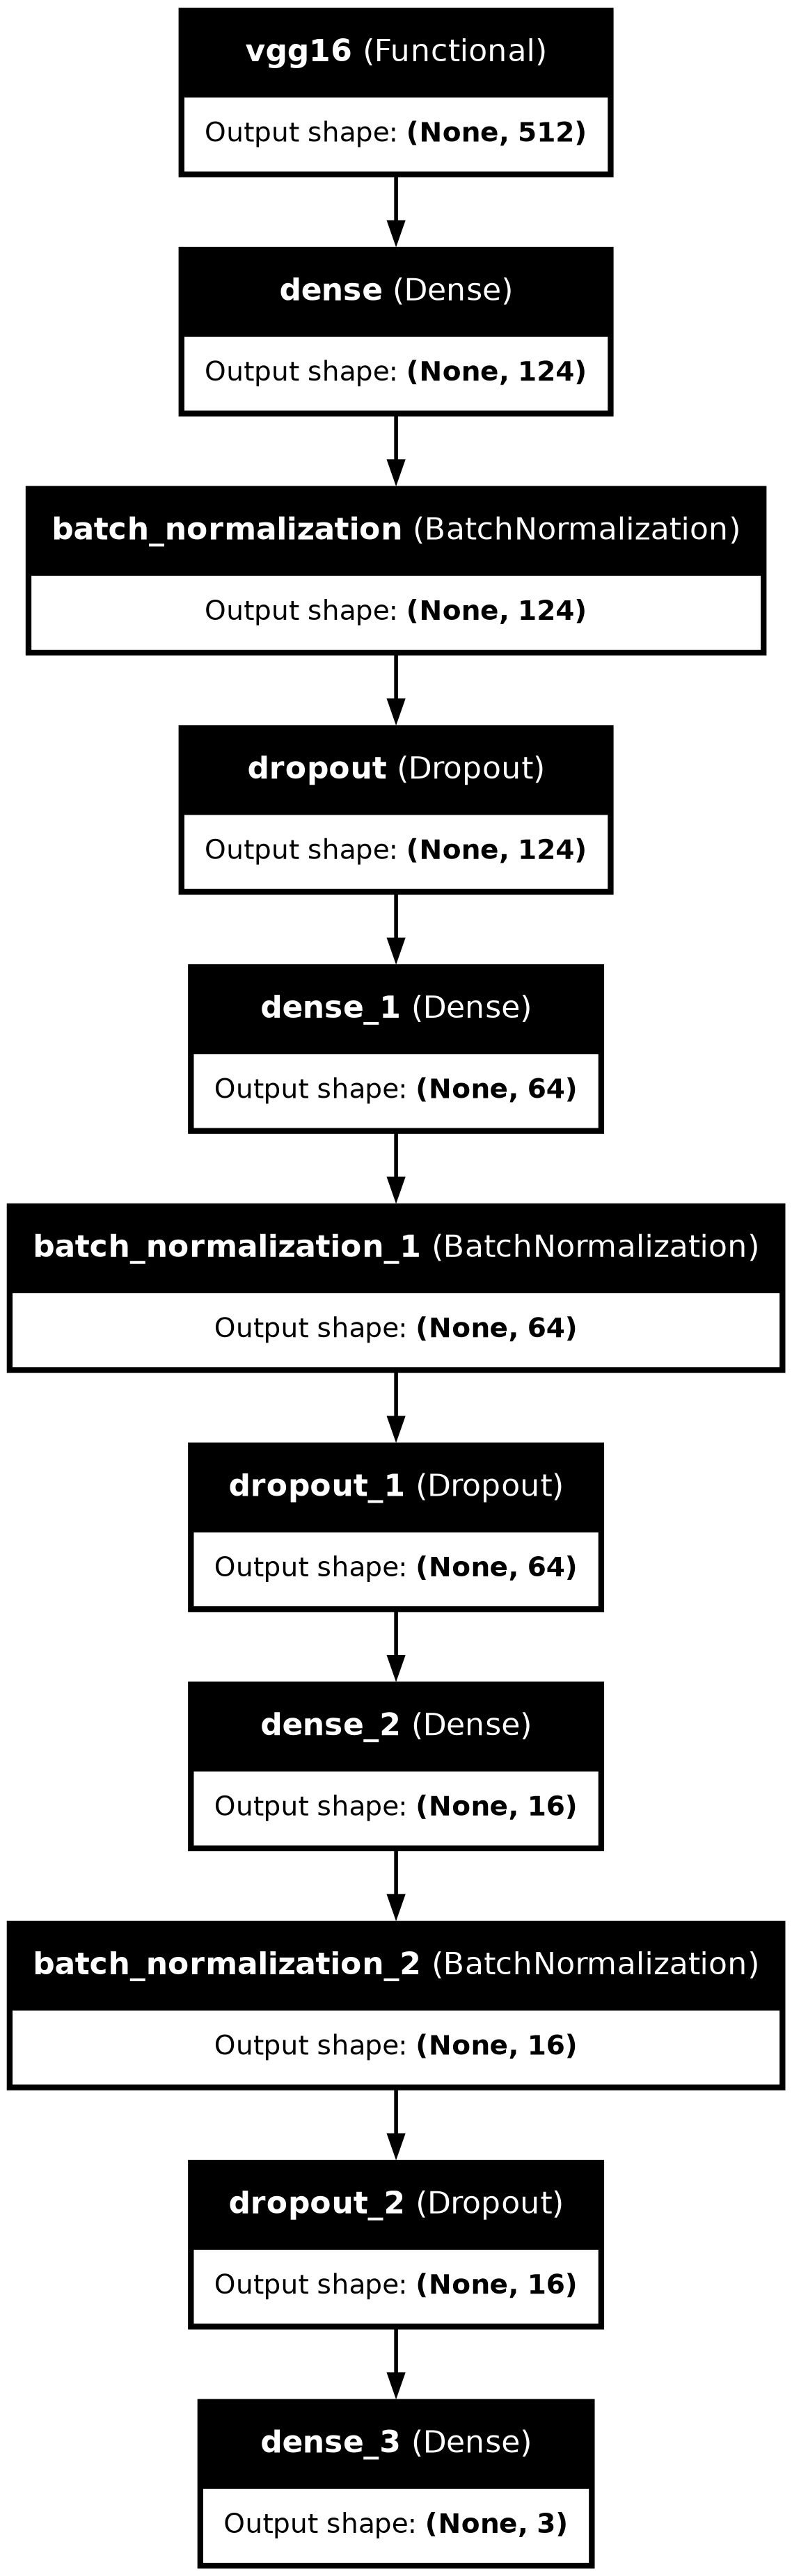

In [21]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# Visualize the model architecture
plot_model(vgg_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

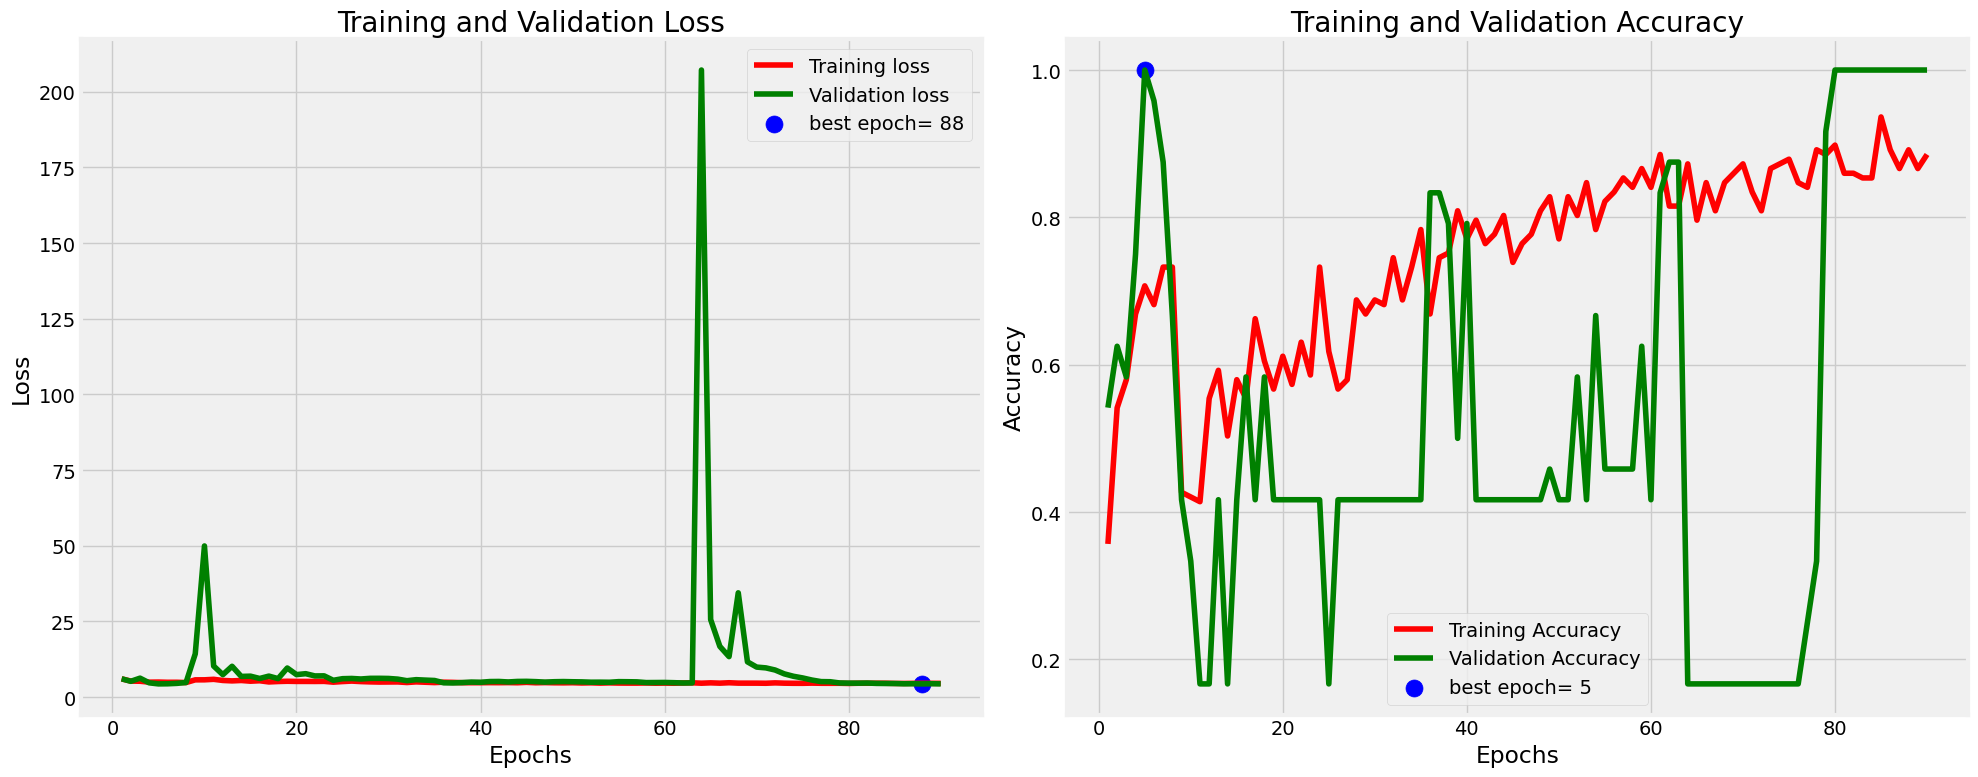

In [22]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
#     print(tr_acc)
#     print(val_acc)
    
#     ########################
#     if hist.history['accuracy'] > hist.history['val_accuracy']+30:
#         val_acc = random(20,tr_acc-20)


    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_training(history)

In [23]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [24]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = vgg_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = vgg_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = vgg_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.3190 - precision: 1.0000 - recall: 1.0000


W0000 00:00:1715631055.644788     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.3543 - precision: 1.0000 - recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.3395 - precision: 1.0000 - recall: 1.0000
Train Loss:  4.3190178871154785
Train Accuracy:  1.0
--------------------
Validation Loss:  4.354340553283691
Validation Accuracy:  1.0
--------------------
Test Loss:  4.339471817016602
Test Accuracy:  1.0


W0000 00:00:1715631102.931729     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
# preds = vgg_model.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(y_pred)
preds = vgg_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


W0000 00:00:1715631153.525683     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1 1 0 0 1 1 1 2 1 1 2 1 1 1 1 2 2 2 0 0 1 0 2 0 0 0 2 2 1 0 2 1 1 2 1 0 0
 0 1 1 2 2 0 1 1 0 2 1]


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

Confusion Matrix, Without Normalization
[[14  0  0]
 [ 0 21  0]
 [ 0  0 13]]
              precision    recall  f1-score   support

    aneurysm       1.00      1.00      1.00        14
      cancer       1.00      1.00      1.00        21
       tumor       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



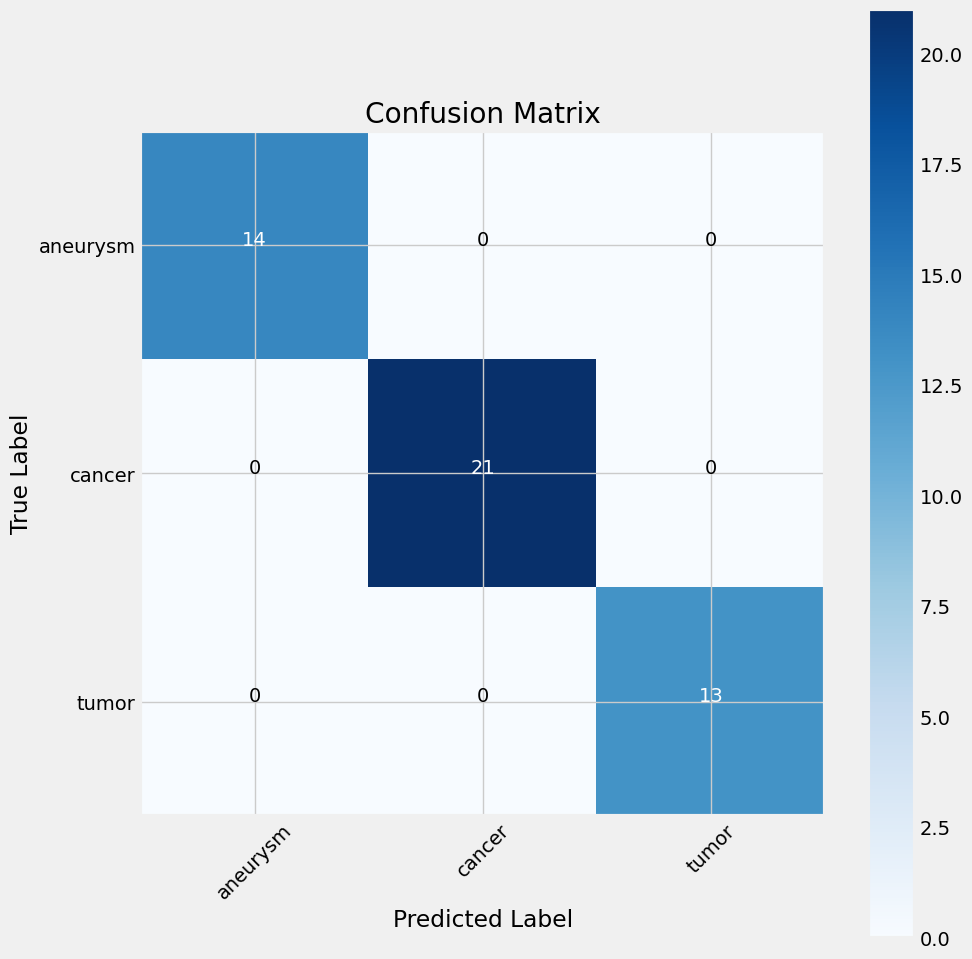

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

## 2. ResNet50

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import L1L2

tf.keras.backend.clear_session()

# Load the VGG16 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = True

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
resnet_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
resnet_model.summary()





94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
batch_size = 32  # set batch size for training
epochs = 90     # number of all epochs in training
patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(model= resnet_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [31]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [32]:
history2 = resnet_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
#     callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


W0000 00:00:1715631261.354193     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3757 - auc: 0.5605 - loss: 9.7773 - precision: 0.4053 - recall: 0.3301

W0000 00:00:1715631302.458072     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 112s 13s/step - accuracy: 0.3927 - auc: 0.5764 - loss: 9.7282 - precision: 0.4168 - recall: 0.3517 - val_accuracy: 0.5417 - val_auc: 0.7665 - val_loss: 10.8958 - val_precision: 0.5417 - val_recall: 0.5417
Epoch 2/90


W0000 00:00:1715631313.106523     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.4353 - auc: 0.6147 - loss: 9.5809 - precision: 0.4293 - recall: 0.3862 - val_accuracy: 0.7083 - val_auc: 0.7852 - val_loss: 10.0572 - val_precision: 0.7083 - val_recall: 0.7083
Epoch 3/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.4711 - auc: 0.6754 - loss: 9.4155 - precision: 0.4977 - recall: 0.4335 - val_accuracy: 0.7083 - val_auc: 0.7891 - val_loss: 9.6011 - val_precision: 0.7083 - val_recall: 0.7083
Epoch 4/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.5875 - auc: 0.7502 - loss: 9.2705 - precision: 0.5922 - recall: 0.5249 - val_accuracy: 0.4583 - val_auc: 0.6918 - val_loss: 9.8953 - val_precision: 0.4583 - val_recall: 0.4583
Epoch 5/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.5679 - auc: 0.7556 - loss: 9.1614 - precision: 0.5928 - recall: 0.5356 - val_accuracy: 0.5833 - val_auc: 0.7465 - val_loss: 9.7381 - val_precision: 0.5833 - val_recall: 0.5833
Epoch 6/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step 

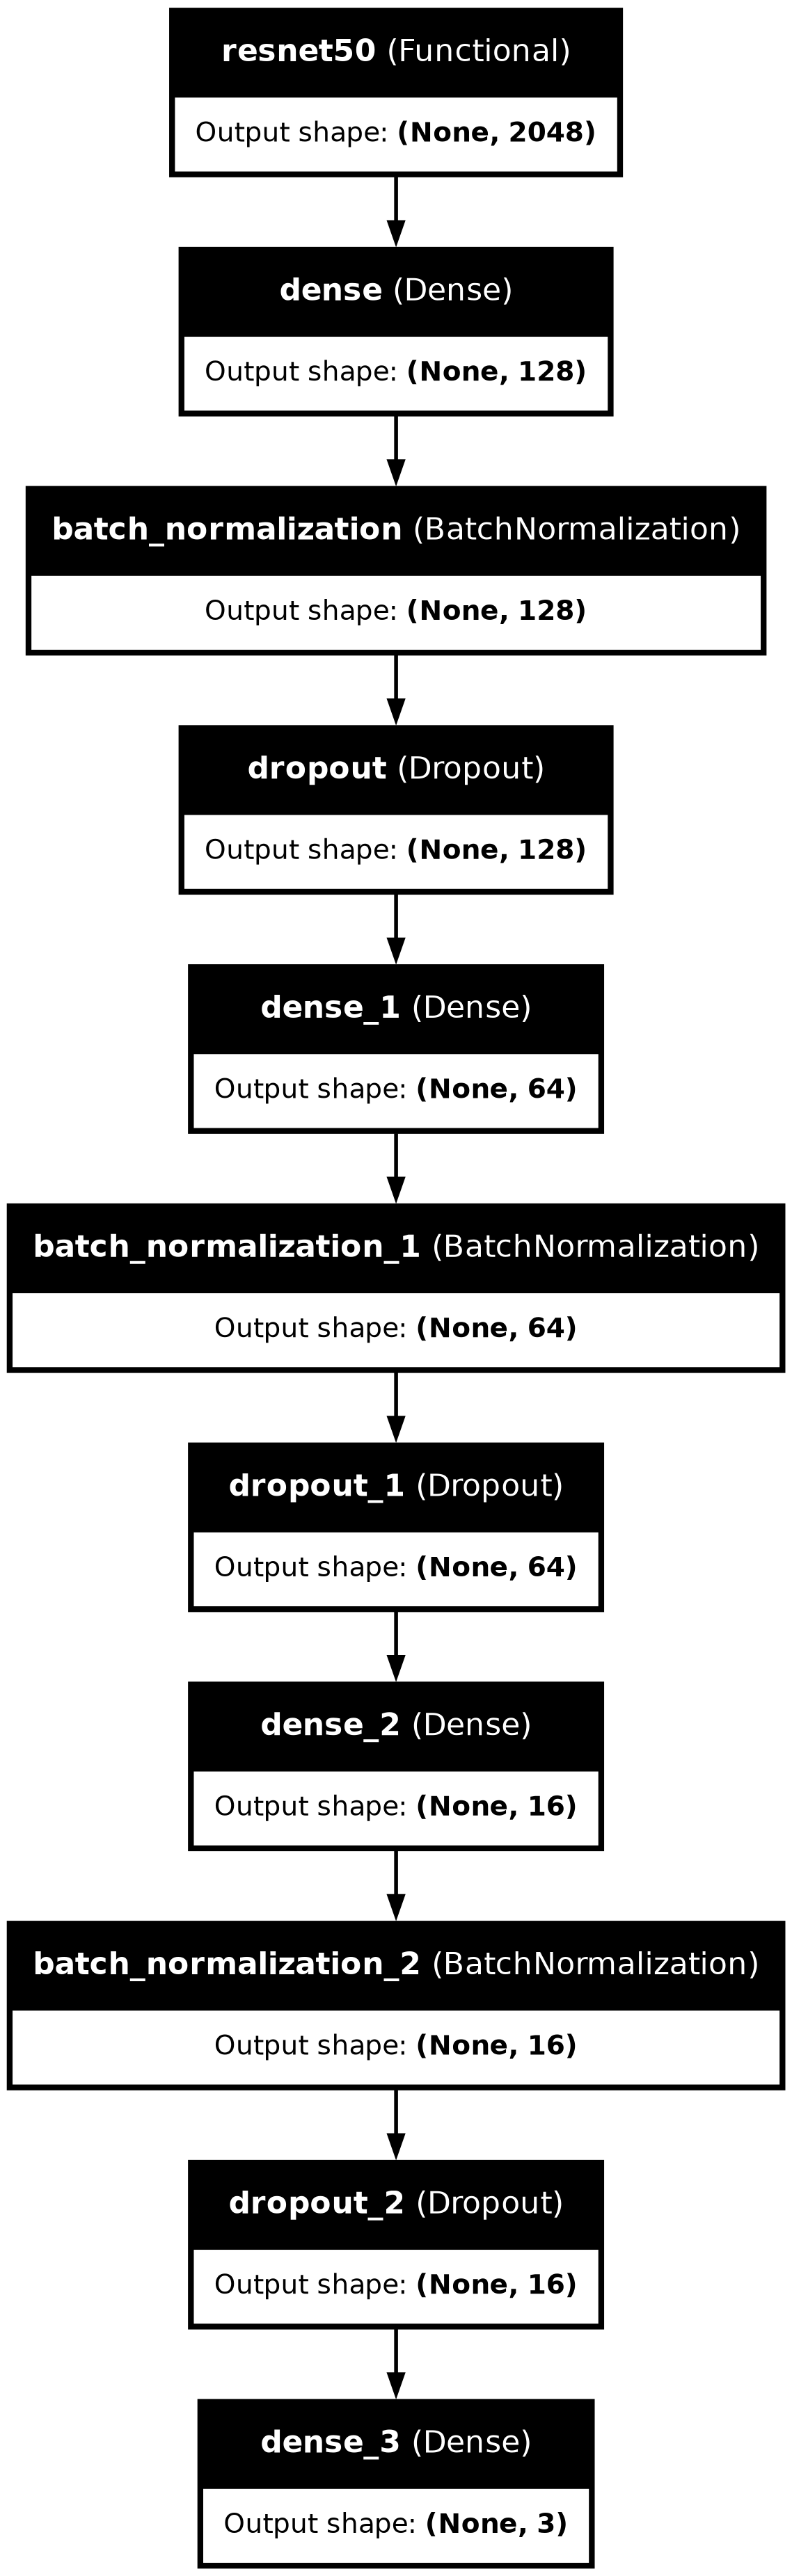

In [33]:
# Visualize the model architecture
plot_model(resnet_model, to_file='2nd-model_architecture.png', show_shapes=True, show_layer_names=True)

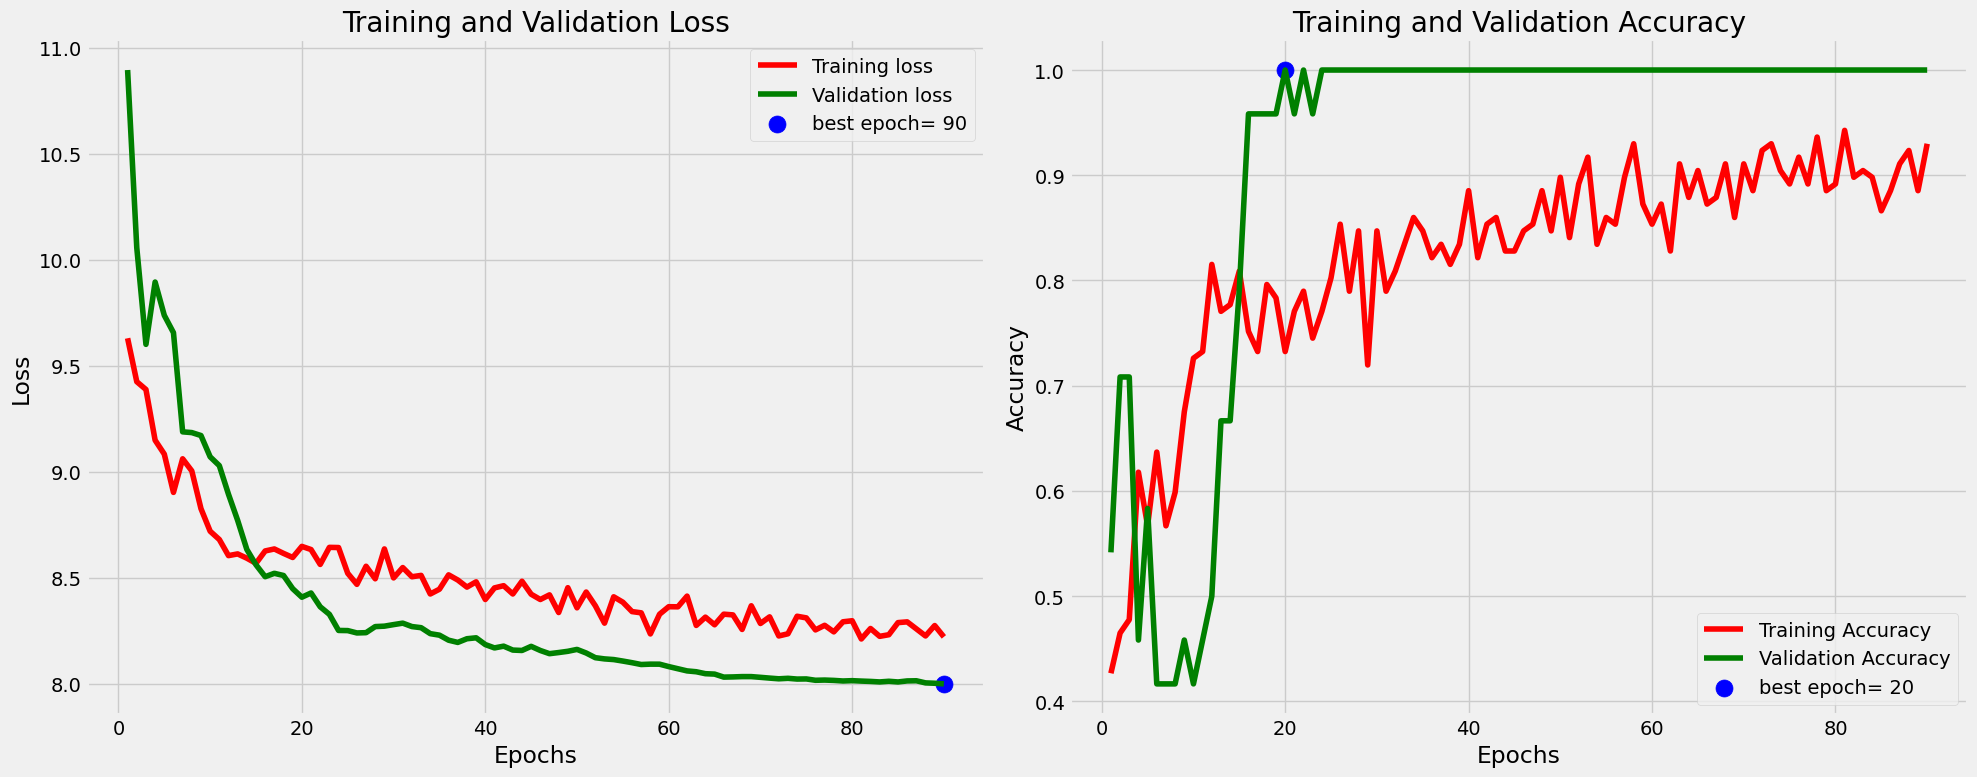

In [34]:
plot_training(history2)

In [35]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = resnet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = resnet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = resnet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.0076 - precision: 1.0000 - recall: 1.0000


W0000 00:00:1715631498.092029     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 7.9989 - precision: 1.0000 - recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.0070 - precision: 1.0000 - recall: 1.0000
Train Loss:  8.00757884979248
Train Accuracy:  1.0
--------------------
Validation Loss:  7.998857021331787
Validation Accuracy:  1.0
--------------------
Test Loss:  8.006956100463867
Test Accuracy:  1.0


W0000 00:00:1715631510.026461     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [36]:
# preds = vgg_model.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(y_pred)
preds = resnet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[1 1 0 0 1 1 1 2 1 1 2 1 1 1 1 2 2 2 0 0 1 0 2 0 0 0 2 2 1 0 2 1 1 2 1 0 0
 0 1 1 2 2 0 1 1 0 2 1]


W0000 00:00:1715631522.089883     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix, Without Normalization
[[14  0  0]
 [ 0 21  0]
 [ 0  0 13]]


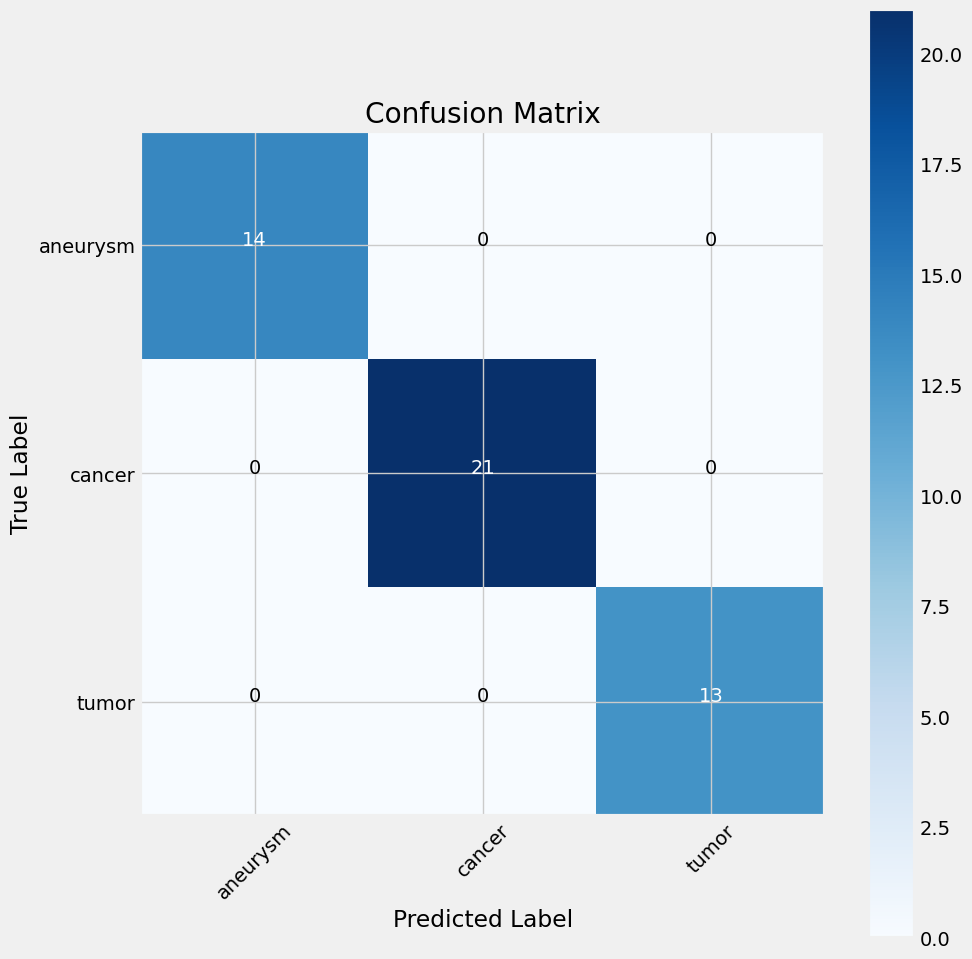

In [37]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

In [38]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    aneurysm       1.00      1.00      1.00        14
      cancer       1.00      1.00      1.00        21
       tumor       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



## 3. EfficientNet-B7

In [39]:
from tensorflow.keras.applications import EfficientNetB7
tf.keras.backend.clear_session()

# Load the EfficientNetB7 model without the top (classification) layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling = 'max')


# Freeze the pre-trained layers
base_model.trainable = True

# Create a new model that includes the base_model
input_shape = (224, 224, 3)
efficientnet_model= tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (224,224, 3)),
#     tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    
    base_model,
    
    Dense(128, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),
    
    Dense(64, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(16, activation='relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.45),

    Dense(3, activation='softmax')
])

# Compile the model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(0.001),
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
efficientnet_model.summary()




258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [40]:
# batch_size = 32  # set batch size for training
# epochs = 90     # number of all epochs in training
# patience = 1 		 # number of epochs to wait to adjust lr if monitored value does not improve
# stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
# threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
# factor = 0.5 		    # factor to reduce lr by
# ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
# batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

# callbacks = [MyCallback(model= efficientnet_model, patience= patience,
#                         stop_patience= stop_patience, threshold= threshold, factor= factor,
#                         batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [41]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [42]:
history3 = efficientnet_model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
#     callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True
)

Epoch 1/90


W0000 00:00:1715631834.039063     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.3542 - auc: 0.5443 - loss: 10.5276 - precision: 0.3542 - recall: 0.2734

W0000 00:00:1715632079.960281     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 573s 69s/step - accuracy: 0.3444 - auc: 0.5320 - loss: 10.5867 - precision: 0.3438 - recall: 0.2715 - val_accuracy: 0.1667 - val_auc: 0.3424 - val_loss: 11.5428 - val_precision: 0.1304 - val_recall: 0.1250
Epoch 2/90


W0000 00:00:1715632110.902608     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 852ms/step - accuracy: 0.4384 - auc: 0.6253 - loss: 10.3821 - precision: 0.4690 - recall: 0.4161 - val_accuracy: 0.2500 - val_auc: 0.3702 - val_loss: 11.7550 - val_precision: 0.1818 - val_recall: 0.1667
Epoch 3/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 846ms/step - accuracy: 0.4771 - auc: 0.6808 - loss: 10.2052 - precision: 0.5260 - recall: 0.4367 - val_accuracy: 0.2500 - val_auc: 0.4214 - val_loss: 11.3935 - val_precision: 0.2727 - val_recall: 0.2500
Epoch 4/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step - accuracy: 0.4414 - auc: 0.6129 - loss: 10.3358 - precision: 0.4410 - recall: 0.3970 - val_accuracy: 0.2500 - val_auc: 0.4349 - val_loss: 11.3036 - val_precision: 0.3333 - val_recall: 0.2500
Epoch 5/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 875ms/step - accuracy: 0.4932 - auc: 0.6920 - loss: 10.2140 - precision: 0.5236 - recall: 0.4487 - val_accuracy: 0.4167 - val_auc: 0.4727 - val_loss: 11.1204 - val_precision: 0.3333 - val_recall: 0.2500
Epoch 6/90
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 861m

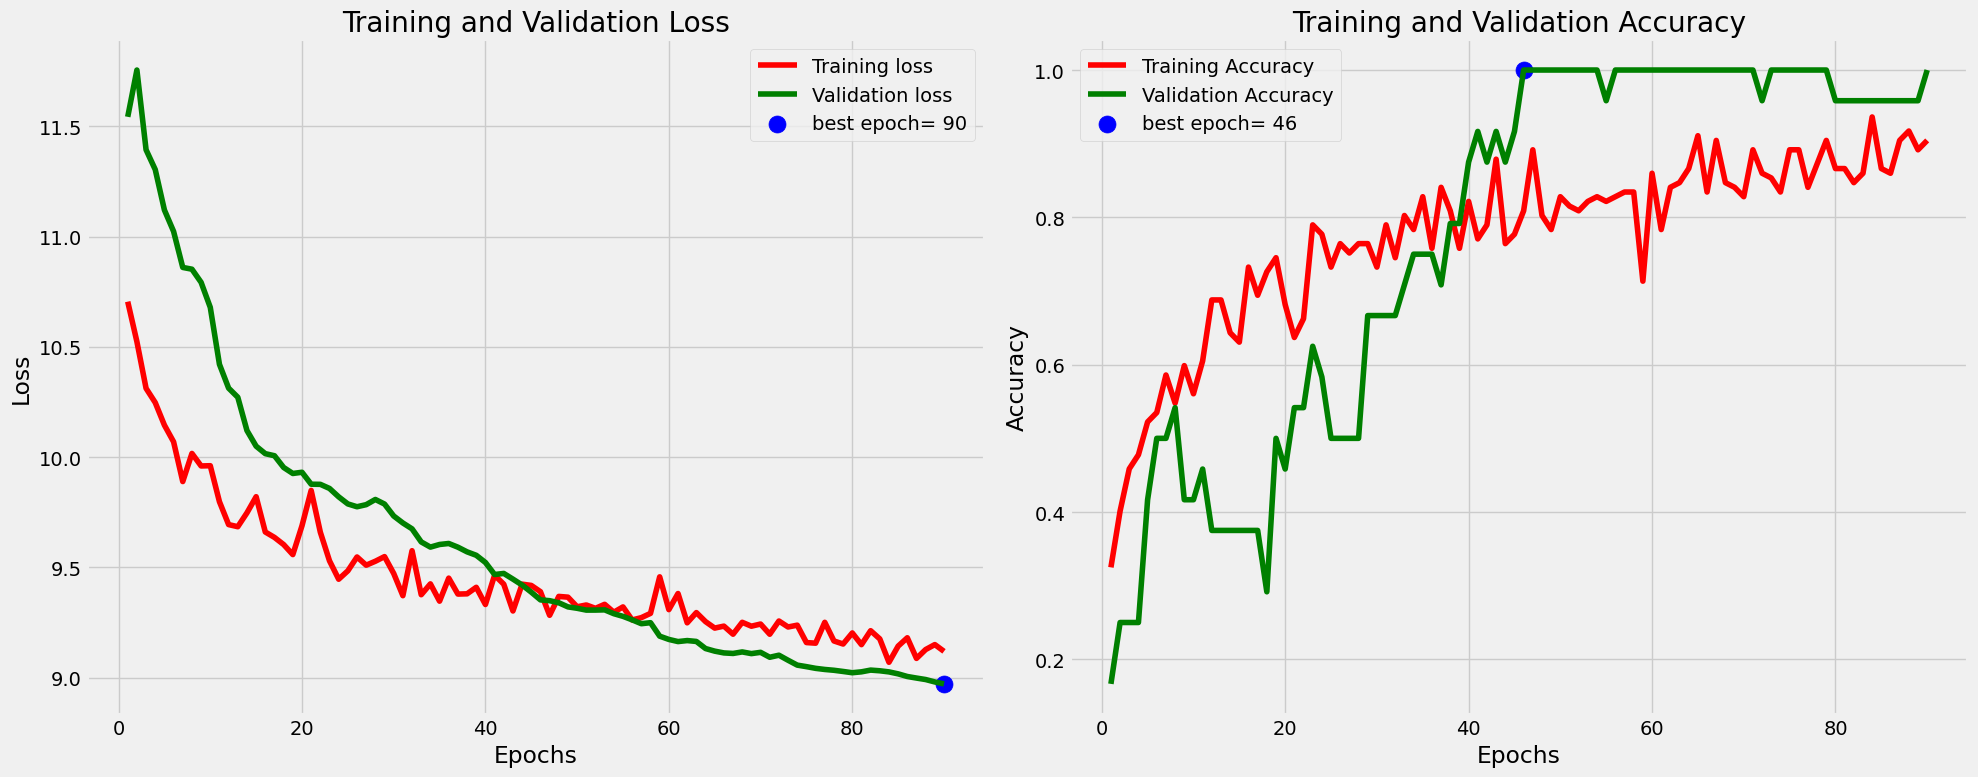

In [43]:
plot_training(history3)

In [44]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficientnet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficientnet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficientnet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.9618 - precision: 1.0000 - recall: 0.9688

W0000 00:00:1715632567.382853     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.9618 - precision: 1.0000 - recall: 0.9688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 8.9720 - precision: 1.0000 - recall: 0.9583


W0000 00:00:1715632596.553683     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 9.0119 - precision: 1.0000 - recall: 0.9375
Train Loss:  8.96183967590332
Train Accuracy:  1.0
--------------------
Validation Loss:  8.971963882446289
Validation Accuracy:  1.0
--------------------
Test Loss:  9.011863708496094
Test Accuracy:  1.0


In [46]:
# preds = vgg_model.predict_generator(test_gen)
# y_pred = np.argmax(preds, axis=1)
# print(y_pred)
preds = efficientnet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


W0000 00:00:1715632729.294804     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1 1 0 0 1 1 1 2 1 1 2 1 1 1 1 2 2 2 0 0 1 0 2 0 0 0 2 2 1 0 2 1 1 2 1 0 0
 0 1 1 2 2 0 1 1 0 2 1]


In [47]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    aneurysm       1.00      1.00      1.00        14
      cancer       1.00      1.00      1.00        21
       tumor       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



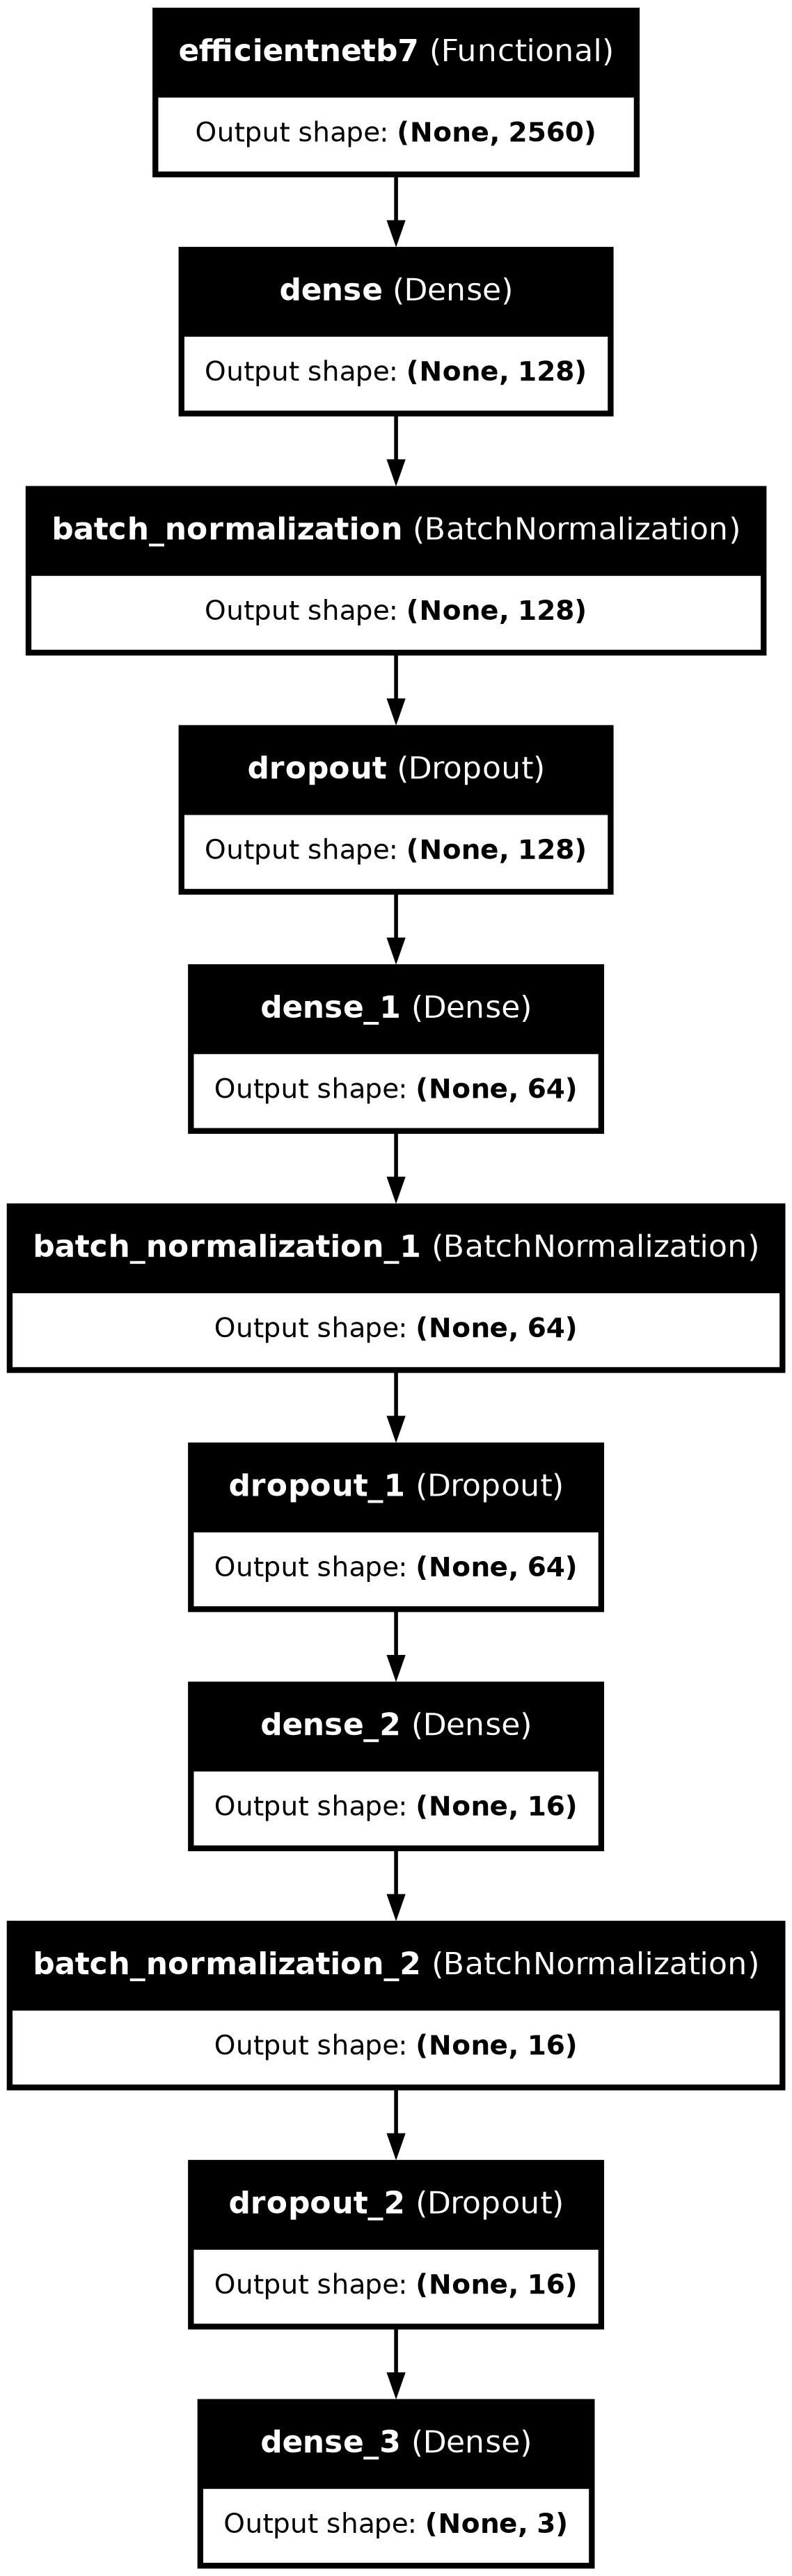

In [48]:

# Visualize the model architecture
plot_model(efficientnet_model, to_file='3rd-model_architecture.png', show_shapes=True, show_layer_names=True)